In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 75,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-1, 1],
    c1 = 2.0,
    c2 = 2.0,
    w = 1.2,
    w_decay = 0.95,
    scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8148148148148148, Loss: 0.57442424915455
Checkpoint 200, Accuracy: 0.8148148148148148, Loss: 0.57442424915455
Checkpoint 300, Accuracy: 0.8148148148148148, Loss: 0.57442424915455
Checkpoint 400, Accuracy: 0.8148148148148148, Loss: 0.57442424915455
Checkpoint 500, Accuracy: 0.8148148148148148, Loss: 0.57442424915455


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None and title is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

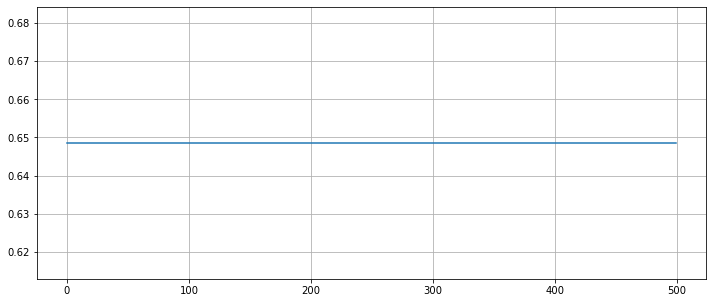

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.8702773  0.081609   0.04811368]
[1. 0. 0.] <-> [0.84728014 0.03980941 0.11291046]
[1. 0. 0.] <-> [0.8886151  0.07174881 0.03963615]
[1. 0. 0.] <-> [0.939261   0.02326793 0.037471  ]
[0. 0. 1.] <-> [0.7722206  0.02338612 0.20439322]
[1. 0. 0.] <-> [0.8609261  0.0654234  0.07365052]
[0. 1. 0.] <-> [0.82119423 0.16747656 0.01132925]
[0. 1. 0.] <-> [0.81516063 0.17330144 0.01153798]
[1. 0. 0.] <-> [0.9458492  0.02167571 0.03247506]
[1. 0. 0.] <-> [0.8544536  0.1256671  0.01987928]
[1. 0. 0.] <-> [0.8824279  0.08365025 0.03392183]
[0. 0. 1.] <-> [0.58497584 0.02047075 0.39455345]
[1. 0. 0.] <-> [0.8632017  0.03030936 0.10648892]
[0. 0. 1.] <-> [0.6786992  0.03758539 0.28371543]
[0. 1. 0.] <-> [0.85620546 0.13165061 0.01214386]
[1. 0. 0.] <-> [0.93887186 0.03170653 0.02942151]
[1. 0. 0.] <-> [0.87464654 0.07636176 0.04899167]
[0. 1. 0.] <-> [0.8123976  0.17745067 0.01015174]
[1. 0. 0.] <-> [0.8666257  0.07311339 0.0602608 ]
[1. 0. 0.] <-> [0.9002852  0.04393077 0.05578407]


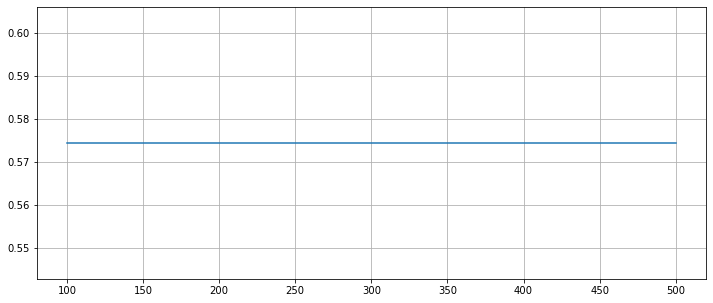

In [12]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

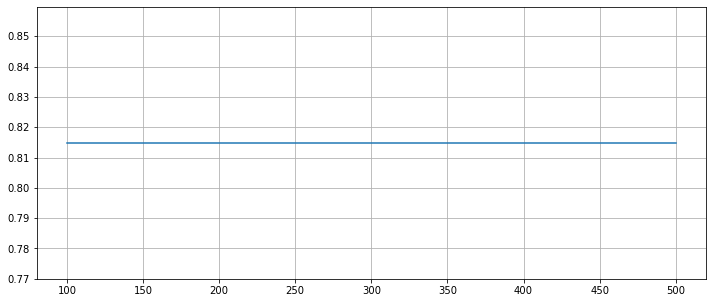

In [13]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[-1.77791508  1.88395876 -2.01784173 -0.42102503  2.23551231]
 bias: 2.6176269143221598

Neuron 1: weights:
[-1.84256846  0.99580833  1.01301361  0.67045936 -0.47837666]
 bias: 1.4756279906805174

Neuron 2: weights:
[-1.36756744 -0.48843815 -1.95271812 -1.96431353  0.51642041]
 bias: -2.2567362614729776

Neuron 3: weights:
[ 0.0788822   1.543433    0.00847321  0.3327648  -2.14207572]
 bias: -0.5020372804446751

$
Layer 2
Neuron 0: weights:
[0.08722087 0.54038236 2.52318046 0.12923169]
 bias: 2.1637305298492837

Neuron 1: weights:
[ 0.99215531  1.61983775 -0.4277497   0.50542645]
 bias: -1.636515394957713

Neuron 2: weights:
[-0.68045198 -0.38940043  0.97156578 -2.75256251]
 bias: 2.2769946113519204

$

